In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import ticker
from tqdm import tqdm

# load the topography data
down_reach = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/downreach_longprofile.csv')
up_reach = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/upreach_longprofile.csv')

# load the groundwater data
SM21_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM21.csv')
SM22_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM22.csv')
SM23_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SM23.csv')
SP22_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SP22.csv')
SP23_GW = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/GW-Hyporheic/groundwater_elevations_SP23.csv')

wells = pd.DataFrame({ #the order for these is GW1 to GW9
    'Distance': [3.1, 8.5, 17, 29.5, 0, 18, 17.2, 36.2, 36.9],
    'Elevation': [2722.372, 2722.683, 2723.117, 2724.179, 2733.515, 2734.527, 2734.794, 2736.657, 2736.795]  
})
piezometers = pd.DataFrame({ #the order for these is P1 to P6 (sll stilling wells)
    'Distance': [0, 20.7, 34.5, 2.6, 35.8, 46.5],
    'Elevation': [2722.252, 2723.599, 2724.714, 2733.502, 2736.62, 2737.685]
})
temprobes = pd.DataFrame({ #the order is TP1 thru TP8
    'Distance': [13, 23, 41, 50, 10.15, 14.6, 31.4, 56.6],
    'Elevation': [2722.652, 2723.389, 2724.88, 2725.338, 2733.665, 2733.998, 2735.669, 2738.474]  
})

### Groundwater Elevations Interpolations 

The idea behind this is to linearly interpolate the groundwater levels spatially, so if we have a time series of groundwater wells in one point in space, we will need to work with a multi-index pandas dataframe

Summer 2021 Groups: 

In [2]:
# GW1 - GW3
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw1_level': SM21_GW.iloc[:, 1],
    'gw3_level': SM21_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = gw_data.loc[time, 'gw1_distance'] # these are always the same actually 
    gw3_distance_at_time = gw_data.loc[time, 'gw3_distance']
    
    if np.isnan(gw1_level_at_time) or np.isnan(gw3_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

# print the DataFrame without NaN values
print(df.dropna())
GW1_3_SM21 = df
duplicates = GW1_3_SM21.duplicated()
GW1_3_SM21_no_duplicates = GW1_3_SM21[~duplicates] # getting rid of duplicated values
unstacked_df = GW1_3_SM21_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW1_3_SM21.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2021-07-29 12:15:00 0.0       2721.257468
                    0.3       2721.276490
                    1.0       2721.320872
                    1.5       2721.352574
                    2.0       2721.384276
...                                   ...
2021-09-22 23:45:00 39.7      2723.490433
                    40.0      2723.508188
                    40.5      2723.537779
                    41.0      2723.567370
                    41.5      2723.596961

[418950 rows x 1 columns]


In [3]:
# GW2 - GW4
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw2_level': SM21_GW.iloc[:, 2],
    'gw4_level': SM21_GW.iloc[:, 4],
    'gw2_distance': wells.iloc[1, 0], # distance of GW2 on the river
    'gw4_distance': wells.iloc[3, 0] # distance of GW4 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw2_level_at_time = gw_data.loc[time, 'gw2_level']
    gw4_level_at_time = gw_data.loc[time, 'gw4_level']
    gw2_distance_at_time = gw_data.loc[time, 'gw2_distance'] # these are always the same actually 
    gw4_distance_at_time = gw_data.loc[time, 'gw4_distance']
    
    if np.isnan(gw2_level_at_time) or np.isnan(gw4_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw2_distance_at_time, gw4_distance_at_time], [gw2_level_at_time, gw4_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW2_4_SM21 = df
duplicates = GW2_4_SM21.duplicated()
GW2_4_SM21_no_duplicates = GW2_4_SM21[~duplicates] # getting rid of duplicated values
unstacked_df = GW2_4_SM21_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW2_4_SM21.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2021-08-12 00:00:00 0.0       2721.131428
                    0.3       2721.155038
                    1.0       2721.210129
                    1.5       2721.249480
                    2.0       2721.288831
...                                   ...
2021-09-22 23:45:00 39.7      2724.245091
                    40.0      2724.269134
                    40.5      2724.309206
                    41.0      2724.349278
                    41.5      2724.389350

[354240 rows x 1 columns]


In [4]:
# GW7 - GW9
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw7_level': SM21_GW.iloc[:, 7],
    'gw9_level': SM21_GW.iloc[:, 9],
    'gw7_distance': wells.iloc[6, 0], # distance of GW7 on the river
    'gw9_distance': wells.iloc[8, 0] # distance of GW9 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, up_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw7_level_at_time = gw_data.loc[time, 'gw7_level']
    gw9_level_at_time = gw_data.loc[time, 'gw9_level']
    gw7_distance_at_time = gw_data.loc[time, 'gw7_distance'] # these are always the same actually 
    gw9_distance_at_time = gw_data.loc[time, 'gw9_distance']
    
    if np.isnan(gw7_level_at_time) or np.isnan(gw9_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw7_distance_at_time, gw9_distance_at_time], [gw7_level_at_time, gw9_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW7_9_SM21 = df
duplicates = GW7_9_SM21.duplicated()
GW7_9_SM21_no_duplicates = GW7_9_SM21[~duplicates] # getting rid of duplicated values
unstacked_df = GW7_9_SM21_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW7_9_SM21.csv') # save the unstacked df to a CSV file

100%|██████████| 5327/5327 [01:13<00:00, 72.49it/s] 


                                 gw_level
time                distance             
2021-08-04 00:00:00 0.0       2732.219663
                    0.7       2732.291454
                    1.0       2732.322222
                    2.0       2732.424781
                    2.6       2732.486317
...                                   ...
2021-09-22 23:45:00 55.9      2737.988070
                    56.5      2738.052344
                    56.6      2738.063056
                    56.9      2738.095193
                    58.0      2738.213027

[537600 rows x 1 columns]


In [5]:
# GW6 - GW8
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM21_GW.iloc[:, 0]),
    'gw6_level': SM21_GW.iloc[:, 6],
    'gw8_level': SM21_GW.iloc[:, 8],
    'gw6_distance': wells.iloc[5, 0], # distance of GW6 on the river
    'gw8_distance': wells.iloc[7, 0] # distance of GW8 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, up_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw6_level_at_time = gw_data.loc[time, 'gw6_level']
    gw8_level_at_time = gw_data.loc[time, 'gw8_level']
    gw6_distance_at_time = gw_data.loc[time, 'gw6_distance'] # these are always the same actually 
    gw8_distance_at_time = gw_data.loc[time, 'gw8_distance']
    
    if np.isnan(gw6_level_at_time) or np.isnan(gw8_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw6_distance_at_time, gw8_distance_at_time], [gw6_level_at_time, gw8_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW6_8_SM21 = df
duplicates = GW6_8_SM21.duplicated()
GW6_8_SM21_no_duplicates = GW6_8_SM21[~duplicates] # getting rid of duplicated values
unstacked_df = GW6_8_SM21_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW6_8_SM21.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2021-07-29 12:15:00 0.0       2731.735315
                    0.7       2731.814860
                    1.0       2731.848951
                    2.0       2731.962586
                    2.6       2732.030768
...                                   ...
2021-09-22 23:45:00 55.9      2737.763980
                    56.5      2737.825642
                    56.6      2737.835919
                    56.9      2737.866750
                    58.0      2737.979796

[596624 rows x 1 columns]


Spring 2022 Groups:

In [6]:
# GW1 - GW3
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP22_GW.iloc[:, 0]),
    'gw1_level': SP22_GW.iloc[:, 1],
    'gw3_level': SP22_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = gw_data.loc[time, 'gw1_distance'] # these are always the same actually 
    gw3_distance_at_time = gw_data.loc[time, 'gw3_distance']
    
    if np.isnan(gw1_level_at_time) or np.isnan(gw3_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

# print the DataFrame without NaN values
print(df.dropna())
GW1_3_SP22 = df
duplicates = GW1_3_SP22.duplicated()
GW1_3_SP22_no_duplicates = GW1_3_SP22[~duplicates] # getting rid of duplicated values
unstacked_df = GW1_3_SP22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW1_3_SP22.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2022-03-02 00:15:00 0.0       2721.160627
                    0.3       2721.177291
                    1.0       2721.216175
                    1.5       2721.243950
                    2.0       2721.271724
...                                   ...
2022-05-05 23:45:00 39.7      2723.748053
                    40.0      2723.768180
                    40.5      2723.801725
                    41.0      2723.835269
                    41.5      2723.868814

[404370 rows x 1 columns]


In [7]:
# GW2 - GW4
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP22_GW.iloc[:, 0]),
    'gw2_level': SP22_GW.iloc[:, 2],
    'gw4_level': SP22_GW.iloc[:, 4],
    'gw2_distance': wells.iloc[1, 0], # distance of GW2 on the river
    'gw4_distance': wells.iloc[3, 0] # distance of GW4 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, down_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw2_level_at_time = gw_data.loc[time, 'gw2_level']
    gw4_level_at_time = gw_data.loc[time, 'gw4_level']
    gw2_distance_at_time = gw_data.loc[time, 'gw2_distance'] # these are always the same actually 
    gw4_distance_at_time = gw_data.loc[time, 'gw4_distance']
    
    if np.isnan(gw2_level_at_time) or np.isnan(gw4_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw2_distance_at_time, gw4_distance_at_time], [gw2_level_at_time, gw4_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW2_4_SP22 = df
duplicates = GW2_4_SP22.duplicated()
GW2_4_SP22_no_duplicates = GW2_4_SP22[~duplicates] # getting rid of duplicated values
unstacked_df = GW2_4_SP22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW2_4_SP22.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2022-03-02 00:15:00 0.0       2721.097297
                    0.3       2721.120078
                    1.0       2721.173232
                    1.5       2721.211199
                    2.0       2721.249166
...                                   ...
2022-05-05 23:45:00 39.7      2724.246996
                    40.0      2724.271356
                    40.5      2724.311957
                    41.0      2724.352558
                    41.5      2724.393158

[241470 rows x 1 columns]


In [8]:
# GW7 - GW9
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP22_GW.iloc[:, 0]),
    'gw7_level': SP22_GW.iloc[:, 7],
    'gw9_level': SP22_GW.iloc[:, 9],
    'gw7_distance': wells.iloc[6, 0], # distance of GW7 on the river
    'gw9_distance': wells.iloc[8, 0] # distance of GW9 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, up_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw7_level_at_time = gw_data.loc[time, 'gw7_level']
    gw9_level_at_time = gw_data.loc[time, 'gw9_level']
    gw7_distance_at_time = gw_data.loc[time, 'gw7_distance'] # these are always the same actually 
    gw9_distance_at_time = gw_data.loc[time, 'gw9_distance']
    
    if np.isnan(gw7_level_at_time) or np.isnan(gw9_level_at_time):
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw7_distance_at_time, gw9_distance_at_time], [gw7_level_at_time, gw9_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW7_9_SP22 = df
duplicates = GW7_9_SP22.duplicated()
GW7_9_SP22_no_duplicates = GW7_9_SP22[~duplicates] # getting rid of duplicated values
unstacked_df = GW7_9_SP22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW7_9_SP22.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2022-03-02 00:15:00 0.0       2732.071923
                    0.7       2732.145731
                    1.0       2732.177363
                    2.0       2732.282802
                    2.6       2732.346066
...                                   ...
2022-05-05 23:45:00 55.9      2737.791847
                    56.5      2737.849795
                    56.6      2737.859453
                    56.9      2737.888427
                    58.0      2737.994665

[327376 rows x 1 columns]


In [10]:
# GW6 - GW8
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP22_GW.iloc[:, 0]),
    'gw6_level': SP22_GW.iloc[:, 6],
    'gw8_level': SP22_GW.iloc[:, 8],
    'gw6_distance': wells.iloc[5, 0], # distance of GW6 on the river
    'gw8_distance': wells.iloc[7, 0] # distance of GW8 on the river
})
gw_data.set_index('time', inplace=True)

# create a new DataFrame for the interpolated values with a MultiIndex of times and distances
index = pd.MultiIndex.from_product([gw_data.index, up_reach.iloc[:, 0]], names=['time', 'distance'])
df = pd.DataFrame(index=index)
df['gw_level'] = np.nan

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in gw_data.index.unique():
    gw6_level_at_time = gw_data.loc[time, 'gw6_level']
    gw8_level_at_time = gw_data.loc[time, 'gw8_level']
    gw6_distance_at_time = gw_data.loc[time, 'gw6_distance'] # these are always the same actually 
    gw8_distance_at_time = gw_data.loc[time, 'gw8_distance']
    
    if np.isnan(gw6_level_at_time).any() or np.isnan(gw8_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw6_distance_at_time, gw8_distance_at_time], [gw6_level_at_time, gw8_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        df.loc[(time, distance), 'gw_level'] = polynomial(distance)

print(df.dropna()) # print the DataFrame without NaN values
GW6_8_SP22 = df
duplicates = GW6_8_SP22.duplicated()
GW6_8_SP22_no_duplicates = GW6_8_SP22[~duplicates] # getting rid of duplicated values
unstacked_df = GW6_8_SP22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
unstacked_df.to_csv('GW6_8_SP22.csv') # save the unstacked df to a CSV file

                                 gw_level
time                distance             
2022-03-02 00:15:00 0.0       2731.825094
                    0.7       2731.901574
                    1.0       2731.934351
                    2.0       2732.043607
                    2.6       2732.109161
...                                   ...
2022-05-05 23:45:00 55.9      2737.808278
                    56.5      2737.871361
                    56.6      2737.881875
                    56.9      2737.913417
                    58.0      2738.029069

[640528 rows x 1 columns]


Summer 2022 Groups: 

In [11]:
# GW1 - GW3
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM22_GW.iloc[:, 0]),
    'gw1_level': SM22_GW.iloc[:, 1],
    'gw3_level': SM22_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = np.array(gw_data.loc[time, 'gw1_distance'])
    gw3_distance_at_time = np.array(gw_data.loc[time, 'gw3_distance'])
    
    if np.isnan(gw1_level_at_time).any() or np.isnan(gw3_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW1_3_SM22 = df
duplicates = GW1_3_SM22.duplicated()
GW1_3_SM22_no_duplicates = GW1_3_SM22[~duplicates] # getting rid of duplicated values
unstacked_df = GW1_3_SM22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW1_3_SM22.csv') # save the unstacked df to a CSV file

100%|██████████| 5281/5281 [00:53<00:00, 97.81it/s] 


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2022-07-30 00:00:00  2721.161257  2721.179271  2721.221302  2721.251325   
2022-07-30 00:15:00  2721.161648  2721.179623  2721.221567  2721.251526   
2022-07-30 00:30:00  2721.163198  2721.181136  2721.222991  2721.252888   
2022-07-30 00:45:00  2721.167348  2721.185223  2721.226932  2721.256724   
2022-07-30 01:00:00  2721.154963  2721.173078  2721.215345  2721.245535   
...                          ...          ...          ...          ...   
2022-09-22 21:45:00  2721.225702   2721.24205  2721.280196  2721.307442   
2022-09-22 22:30:00  2721.217977  2721.234565  2721.273269  2721.300915   
2022-09-22 22:45:00  2721.223689  2721.240175  2721.278644  2721.306122   
2022-09-22 23:30:00  2721.242825  2721.258871  2721.296311  2721.323055   
2022-09-22 23:45:00   272

In [12]:
# GW2 - GW4
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM22_GW.iloc[:, 0]),
    'gw2_level': SM22_GW.iloc[:, 2],
    'gw4_level': SM22_GW.iloc[:, 4],
    'gw2_distance': wells.iloc[1, 0], # distance of GW1 on the river
    'gw4_distance': wells.iloc[3, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw2_level_at_time = gw_data.loc[time, 'gw2_level']
    gw4_level_at_time = gw_data.loc[time, 'gw4_level']
    gw2_distance_at_time = np.array(gw_data.loc[time, 'gw2_distance'])
    gw4_distance_at_time = np.array(gw_data.loc[time, 'gw4_distance'])
    
    if np.isnan(gw2_level_at_time).any() or np.isnan(gw4_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw2_distance_at_time, gw4_distance_at_time], [gw2_level_at_time, gw4_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW2_4_SM22 = df
duplicates = GW2_4_SM22.duplicated()
GW2_4_SM22_no_duplicates = GW2_4_SM22[~duplicates] # getting rid of duplicated values
unstacked_df = GW2_4_SM22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW2_4_SM22.csv') # save the unstacked df to a CSV file

100%|██████████| 5281/5281 [00:53<00:00, 99.43it/s] 


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2022-07-30 00:00:00  2721.113129  2721.136463  2721.190912  2721.229803   
2022-07-30 00:15:00  2721.109039  2721.132416  2721.186961  2721.225922   
2022-07-30 00:30:00  2721.108449  2721.131826  2721.186371  2721.225332   
2022-07-30 00:45:00  2721.106571  2721.129972  2721.184576  2721.223578   
2022-07-30 01:00:00  2721.102456  2721.125941  2721.180739   2721.21988   
...                          ...          ...          ...          ...   
2022-09-22 22:45:00  2721.050908  2721.076415  2721.135932  2721.178444   
2022-09-22 23:00:00  2721.053246  2721.078711  2721.138131  2721.180574   
2022-09-22 23:15:00  2721.056641   2721.08209  2721.141471  2721.183886   
2022-09-22 23:30:00  2721.058629   2721.08407  2721.143431  2721.185832   
2022-09-22 23:45:00  2721

In [13]:
# GW7 - GW9
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM22_GW.iloc[:, 0]),
    'gw7_level': SM22_GW.iloc[:, 7],
    'gw9_level': SM22_GW.iloc[:, 9],
    'gw7_distance': wells.iloc[6, 0], # distance of GW7 on the river
    'gw9_distance': wells.iloc[8, 0] # distance of GW9 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw7_level_at_time = gw_data.loc[time, 'gw7_level']
    gw9_level_at_time = gw_data.loc[time, 'gw9_level']
    gw7_distance_at_time = np.array(gw_data.loc[time, 'gw7_distance']) 
    gw9_distance_at_time = np.array(gw_data.loc[time, 'gw9_distance'])
    
    if np.isnan(gw7_level_at_time).any() or np.isnan(gw9_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw7_distance_at_time, gw9_distance_at_time], [gw7_level_at_time, gw9_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW7_9_SM22 = df
duplicates = GW7_9_SM22.duplicated()
GW7_9_SM22_no_duplicates = GW7_9_SM22[~duplicates] # getting rid of duplicated values
unstacked_df = GW7_9_SM22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW7_9_SM22.csv') # save the unstacked df to a CSV file

100%|██████████| 5281/5281 [00:27<00:00, 191.84it/s] 


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2022-07-30 00:00:00  2732.091685  2732.164191  2732.195265  2732.298844   
2022-07-30 00:15:00  2732.089492  2732.162039  2732.193131   2732.29677   
2022-07-30 00:30:00  2732.088902  2732.161449  2732.192541   2732.29618   
2022-07-30 00:45:00  2732.086951  2732.159602  2732.190738  2732.294524   
2022-07-30 01:00:00  2732.091179  2732.163705  2732.194788  2732.298397   
...                          ...          ...          ...          ...   
2022-09-22 22:30:00  2732.165983   2732.23798  2732.268836  2732.371689   
2022-09-22 23:00:00  2732.162927  2732.235049  2732.265958  2732.368988   
2022-09-22 23:15:00  2732.167735  2732.239732  2732.270588  2732.373441   
2022-09-22 23:30:00  2732.171013  2732.242948  2732.273777  2732.376541   
2022-09-22 23:45:00  2732

In [14]:
# GW6 - GW8
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM22_GW.iloc[:, 0]),
    'gw6_level': SM22_GW.iloc[:, 6],
    'gw8_level': SM22_GW.iloc[:, 8],
    'gw6_distance': wells.iloc[5, 0], # distance of GW6 on the river
    'gw8_distance': wells.iloc[7, 0] # distance of GW8 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw6_level_at_time = gw_data.loc[time, 'gw6_level']
    gw8_level_at_time = gw_data.loc[time, 'gw8_level']
    gw6_distance_at_time = gw_data.loc[time, 'gw6_distance']  
    gw8_distance_at_time = gw_data.loc[time, 'gw8_distance']
    
    if np.isnan(gw6_level_at_time).any() or np.isnan(gw8_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw6_distance_at_time, gw8_distance_at_time], [gw6_level_at_time, gw8_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW6_8_SM22 = df
duplicates = GW6_8_SM22.duplicated()
GW6_8_SM22_no_duplicates = GW6_8_SM22[~duplicates] # getting rid of duplicated values
unstacked_df = GW6_8_SM22_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW6_8_SM22.csv') # save the unstacked df to a CSV file

100%|██████████| 5281/5281 [01:03<00:00, 82.66it/s] 


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2022-07-30 00:00:00  2732.382823  2732.449083  2732.477481  2732.572139   
2022-07-30 00:30:00  2732.381657  2732.447963   2732.47638  2732.571102   
2022-07-30 00:45:00  2732.383388  2732.449627  2732.478015  2732.572641   
2022-07-30 01:45:00  2732.386279  2732.452405  2732.480745  2732.575211   
2022-07-30 02:00:00  2732.389741  2732.455732  2732.484014  2732.578287   
...                          ...          ...          ...          ...   
2022-09-22 22:00:00  2732.383639  2732.449609  2732.477882  2732.572126   
2022-09-22 22:45:00  2732.375583  2732.441913  2732.470339  2732.565096   
2022-09-22 23:00:00  2732.374987  2732.441294  2732.469711  2732.564436   
2022-09-22 23:15:00  2732.375006   2732.44138  2732.469827  2732.564647   
2022-09-22 23:30:00  2732

Spring 2023

In [15]:
# GW1 - GW3
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP23_GW.iloc[:, 0]),
    'gw1_level': SP23_GW.iloc[:, 1],
    'gw3_level': SP23_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = np.array(gw_data.loc[time, 'gw1_distance'])
    gw3_distance_at_time = np.array(gw_data.loc[time, 'gw3_distance'])
    
    if np.isnan(gw1_level_at_time).any() or np.isnan(gw3_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW1_3_SP23 = df
duplicates = GW1_3_SP23.duplicated()
GW1_3_SP23_no_duplicates = GW1_3_SP23[~duplicates] # getting rid of duplicated values
unstacked_df = GW1_3_SP23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW1_3_SP23.csv') # save the unstacked df to a CSV file

100%|██████████| 10656/10656 [01:48<00:00, 98.26it/s] 


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2023-03-02 00:00:00   2721.28193  2721.297577  2721.334085  2721.360162   
2023-03-02 00:30:00  2721.284069  2721.299791  2721.336475  2721.362678   
2023-03-02 00:45:00   2721.28057  2721.296292  2721.332976  2721.359179   
2023-03-02 01:00:00  2721.282187  2721.297922  2721.334636   2721.36086   
2023-03-02 01:15:00  2721.280168  2721.295927    2721.3327  2721.358967   
...                          ...          ...          ...          ...   
2023-06-20 13:30:00  2721.445711  2721.457758  2721.485866  2721.505943   
2023-06-20 20:00:00  2721.442544  2721.454615  2721.482782    2721.5029   
2023-06-20 21:15:00  2721.444223  2721.456358  2721.484671  2721.504894   
2023-06-20 21:45:00  2721.445772  2721.457868  2721.486094  2721.506255   
2023-06-20 22:15:00  2721

In [16]:
# GW2 - GW4
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP23_GW.iloc[:, 0]),
    'gw2_level': SP23_GW.iloc[:, 2],
    'gw4_level': SP23_GW.iloc[:, 4],
    'gw2_distance': wells.iloc[1, 0], # distance of GW2 on the river
    'gw4_distance': wells.iloc[3, 0] # distance of GW4 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw2_level_at_time = gw_data.loc[time, 'gw2_level']
    gw4_level_at_time = gw_data.loc[time, 'gw4_level']
    gw2_distance_at_time = gw_data.loc[time, 'gw2_distance']  # retrieve the distance for gw2 at this time
    gw4_distance_at_time = gw_data.loc[time, 'gw4_distance']  # retrieve the distance for gw4 at this time
    
    if np.isnan(gw2_level_at_time).any() or np.isnan(gw4_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw2_distance_at_time, gw4_distance_at_time], [gw2_level_at_time, gw4_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW2_4_SP23 = df
duplicates = GW2_4_SP23.duplicated()
GW2_4_SP23_no_duplicates = GW2_4_SP23[~duplicates] # getting rid of duplicated values
unstacked_df = GW2_4_SP23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW2_4_SP23.csv') # save the unstacked df to a CSV file

100%|██████████| 10656/10656 [01:54<00:00, 93.03it/s]


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2023-03-02 00:00:00  2720.905766  2720.933474  2720.998125  2721.044305   
2023-03-02 00:15:00  2720.905887  2720.933611  2720.998301  2721.044508   
2023-03-02 00:30:00  2720.909514  2720.937213  2721.001845   2721.04801   
2023-03-02 00:45:00  2720.907764  2720.935463  2721.000095   2721.04626   
2023-03-02 01:00:00  2720.907871  2720.935587  2721.000257   2721.04645   
...                          ...          ...          ...          ...   
2023-06-20 20:45:00  2720.962039  2720.989573  2721.053818  2721.099708   
2023-06-20 21:30:00  2720.964259  2720.991776  2721.055983  2721.101845   
2023-06-20 22:45:00  2720.960869  2720.988403  2721.052648  2721.098538   
2023-06-20 23:00:00  2720.960161   2720.98772  2721.052023  2721.097955   
2023-06-20 23:30:00   272

In [17]:
# GW7 - GW9
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP23_GW.iloc[:, 0]),
    'gw7_level': SP23_GW.iloc[:, 7],
    'gw9_level': SP23_GW.iloc[:, 9],
    'gw7_distance': wells.iloc[6, 0], # distance of GW7 on the river
    'gw9_distance': wells.iloc[8, 0] # distance of GW9 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw7_level_at_time = gw_data.loc[time, 'gw7_level']
    gw9_level_at_time = gw_data.loc[time, 'gw9_level']
    gw7_distance_at_time = np.array(gw_data.loc[time, 'gw7_distance']) 
    gw9_distance_at_time = np.array(gw_data.loc[time, 'gw9_distance'])
    
    if np.isnan(gw7_level_at_time).any() or np.isnan(gw9_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw7_distance_at_time, gw9_distance_at_time], [gw7_level_at_time, gw9_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW7_9_SP23 = df
duplicates = GW7_9_SP23.duplicated()
GW7_9_SP23_no_duplicates = GW7_9_SP23[~duplicates] # getting rid of duplicated values
unstacked_df = GW7_9_SP23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW7_9_SP23.csv') # save the unstacked df to a CSV file

100%|██████████| 10656/10656 [01:22<00:00, 129.45it/s]


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2023-03-02 00:00:00  2732.438499  2732.505575  2732.534322  2732.630145   
2023-03-02 00:15:00  2732.440247  2732.507323   2732.53607  2732.631894   
2023-03-02 00:30:00  2732.441418  2732.508494  2732.537241  2732.633064   
2023-03-02 00:45:00  2732.436391  2732.503529  2732.532303  2732.628215   
2023-03-02 01:00:00  2732.439226  2732.506344  2732.535109  2732.630992   
...                          ...          ...          ...          ...   
2023-06-20 18:15:00  2732.565935  2732.630938  2732.658796  2732.751656   
2023-06-20 19:45:00  2732.564774  2732.629777  2732.657635  2732.750496   
2023-06-20 22:00:00  2732.566597   2732.63162  2732.659487  2732.752377   
2023-06-20 22:15:00  2732.569875  2732.634836  2732.662676  2732.755477   
2023-06-20 22:30:00  2732

In [18]:
# GW6 - GW8
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SP23_GW.iloc[:, 0]),
    'gw6_level': SP23_GW.iloc[:, 6],
    'gw8_level': SP23_GW.iloc[:, 8],
    'gw6_distance': wells.iloc[5, 0], # distance of GW6 on the river
    'gw8_distance': wells.iloc[7, 0] # distance of GW8 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw6_level_at_time = gw_data.loc[time, 'gw6_level']
    gw8_level_at_time = gw_data.loc[time, 'gw8_level']
    gw6_distance_at_time = gw_data.loc[time, 'gw6_distance']  
    gw8_distance_at_time = gw_data.loc[time, 'gw8_distance']
    
    if np.isnan(gw6_level_at_time).any() or np.isnan(gw8_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw6_distance_at_time, gw8_distance_at_time], [gw6_level_at_time, gw8_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW6_8_SP23 = df
duplicates = GW6_8_SP23.duplicated()
GW6_8_SP23_no_duplicates = GW6_8_SP23[~duplicates] # getting rid of duplicated values
unstacked_df = GW6_8_SP23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW6_8_SP23.csv') # save the unstacked df to a CSV file

100%|██████████| 10656/10656 [02:05<00:00, 85.21it/s]


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2023-03-02 00:00:00  2732.384536  2732.449567  2732.477437  2732.570338   
2023-03-02 00:15:00  2732.385128  2732.450204  2732.478093  2732.571059   
2023-03-02 00:30:00  2732.390934  2732.455897  2732.483739  2732.576544   
2023-03-02 00:45:00  2732.385704  2732.450735  2732.478605  2732.571506   
2023-03-02 01:00:00  2732.388609  2732.453617  2732.481478  2732.574347   
...                          ...          ...          ...          ...   
2023-06-20 19:15:00   2732.47555  2732.539904  2732.567484  2732.659419   
2023-06-20 20:00:00  2732.476711  2732.540997  2732.568548  2732.660386   
2023-06-20 22:15:00  2732.480773  2732.545059  2732.572611  2732.664449   
2023-06-20 22:30:00  2732.482503  2732.546723  2732.574246  2732.665988   
2023-06-20 23:15:00  2732

Summer 2023 Groups:

In [19]:
# GW1 - GW3
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM23_GW.iloc[:, 0]),
    'gw1_level': SM23_GW.iloc[:, 1],
    'gw3_level': SM23_GW.iloc[:, 3],
    'gw1_distance': wells.iloc[0, 0], # distance of GW1 on the river
    'gw3_distance': wells.iloc[2, 0] # distance of GW3 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw1_level_at_time = gw_data.loc[time, 'gw1_level']
    gw3_level_at_time = gw_data.loc[time, 'gw3_level']
    gw1_distance_at_time = np.array(gw_data.loc[time, 'gw1_distance'])
    gw3_distance_at_time = np.array(gw_data.loc[time, 'gw3_distance'])
    
    if np.isnan(gw1_level_at_time).any() or np.isnan(gw3_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw1_distance_at_time, gw3_distance_at_time], [gw1_level_at_time, gw3_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW1_3_SM23 = df
duplicates = GW1_3_SM23.duplicated()
GW1_3_SM23_no_duplicates = GW1_3_SM23[~duplicates] # getting rid of duplicated values
unstacked_df = GW1_3_SM23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW1_3_SM23.csv') # save the unstacked df to a CSV file

100%|██████████| 8448/8448 [01:29<00:00, 93.87it/s]


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2023-06-22 00:00:00  2721.388553  2721.401639  2721.432172  2721.453981   
2023-06-22 00:15:00  2721.387193  2721.400241  2721.430686  2721.452433   
2023-06-22 00:45:00  2721.387583  2721.400706  2721.431328    2721.4532   
2023-06-22 01:00:00  2721.388234  2721.401294  2721.431769  2721.453536   
2023-06-22 02:00:00  2721.386803  2721.399889  2721.430422  2721.452231   
...                          ...          ...          ...          ...   
2023-09-17 17:45:00  2721.552562  2721.563135  2721.587804  2721.605424   
2023-09-17 19:15:00  2721.554703  2721.565237  2721.589818  2721.607376   
2023-09-17 22:45:00  2721.556062  2721.566635  2721.591304  2721.608924   
2023-09-17 23:15:00  2721.558274  2721.568745  2721.593179  2721.610632   
2023-09-17 23:30:00  2721

In [20]:
# GW2 - GW4
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM23_GW.iloc[:, 0]),
    'gw2_level': SM23_GW.iloc[:, 2],
    'gw4_level': SM23_GW.iloc[:, 4],
    'gw2_distance': wells.iloc[1, 0], # distance of GW2 on the river
    'gw4_distance': wells.iloc[3, 0] # distance of GW4 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw2_level_at_time = gw_data.loc[time, 'gw2_level']
    gw4_level_at_time = gw_data.loc[time, 'gw4_level']
    gw2_distance_at_time = gw_data.loc[time, 'gw2_distance']  # retrieve the distance for gw2 at this time
    gw4_distance_at_time = gw_data.loc[time, 'gw4_distance']  # retrieve the distance for gw4 at this time
    
    if np.isnan(gw2_level_at_time).any() or np.isnan(gw4_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw2_distance_at_time, gw4_distance_at_time], [gw2_level_at_time, gw4_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=down_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in down_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW2_4_SM23 = df
duplicates = GW2_4_SM23.duplicated()
GW2_4_SM23_no_duplicates = GW2_4_SM23[~duplicates] # getting rid of duplicated values
unstacked_df = GW2_4_SM23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW2_4_SM23.csv') # save the unstacked df to a CSV file

100%|██████████| 8448/8448 [01:30<00:00, 93.77it/s]


                        gw_level                                         \
distance                    0.0          0.3          1.0          1.5    
time                                                                      
2023-06-22 00:00:00  2720.956661  2720.984219  2721.048523  2721.094455   
2023-06-22 00:15:00  2720.954202  2720.981786  2721.046148  2721.092121   
2023-06-22 00:30:00  2720.957475  2720.985026   2721.04931  2721.095228   
2023-06-22 00:45:00  2720.954778  2720.982362  2721.046725  2721.092698   
2023-06-22 02:00:00  2720.948232  2720.975882    2721.0404  2721.086485   
...                          ...          ...          ...          ...   
2023-09-17 13:30:00  2720.893673  2720.920964  2720.984643  2721.030127   
2023-09-17 19:30:00  2720.887126  2720.914483  2720.978317  2721.023913   
2023-09-17 21:00:00   2720.89123  2720.918545  2720.982282  2721.027808   
2023-09-17 22:00:00  2720.894246  2720.921579  2720.985354  2721.030908   
2023-09-17 22:30:00  2720

In [21]:
# GW7 - GW9
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM23_GW.iloc[:, 0]),
    'gw7_level': SM23_GW.iloc[:, 7],
    'gw9_level': SM23_GW.iloc[:, 9],
    'gw7_distance': wells.iloc[6, 0], # distance of GW7 on the river
    'gw9_distance': wells.iloc[8, 0] # distance of GW9 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw7_level_at_time = gw_data.loc[time, 'gw7_level']
    gw9_level_at_time = gw_data.loc[time, 'gw9_level']
    gw7_distance_at_time = np.array(gw_data.loc[time, 'gw7_distance']) 
    gw9_distance_at_time = np.array(gw_data.loc[time, 'gw9_distance'])
    
    if np.isnan(gw7_level_at_time).any() or np.isnan(gw9_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw7_distance_at_time, gw9_distance_at_time], [gw7_level_at_time, gw9_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW7_9_SM23 = df
duplicates = GW7_9_SM23.duplicated()
GW7_9_SM23_no_duplicates = GW7_9_SM23[~duplicates] # getting rid of duplicated values
unstacked_df = GW7_9_SM23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW7_9_SM23.csv') # save the unstacked df to a CSV file

100%|██████████| 8448/8448 [00:49<00:00, 171.86it/s] 


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2023-06-22 00:00:00  2732.411546  2732.478908  2732.507778  2732.604009   
2023-06-22 00:15:00  2732.414824  2732.482124  2732.510967  2732.607109   
2023-06-22 00:30:00  2732.416574  2732.483874  2732.512717  2732.608859   
2023-06-22 00:45:00  2732.413296  2732.480658  2732.509528  2732.605759   
2023-06-22 01:45:00  2732.412052  2732.479394  2732.508254  2732.604457   
...                          ...          ...          ...          ...   
2023-09-17 18:45:00  2732.386235  2732.454259  2732.483412   2732.58059   
2023-09-17 19:30:00  2732.385571  2732.453575  2732.482719  2732.579867   
2023-09-17 21:00:00  2732.387984  2732.456008  2732.485161  2732.582339   
2023-09-17 22:00:00  2732.390894  2732.458918  2732.488071  2732.585249   
2023-09-17 23:15:00  2732

In [22]:
# GW6 - GW8
# ensure that the time series data for the two wells are in a DataFrame with a DateTimeIndex
gw_data = pd.DataFrame({
    'time': pd.to_datetime(SM23_GW.iloc[:, 0]),
    'gw6_level': SM23_GW.iloc[:, 6],
    'gw8_level': SM23_GW.iloc[:, 8],
    'gw6_distance': wells.iloc[5, 0], # distance of GW6 on the river
    'gw8_distance': wells.iloc[7, 0] # distance of GW8 on the river
})
gw_data.set_index('time', inplace=True)

# Initialize an empty list to store the results
dfs = []

# loop over each unique time, slice the DataFrame for that time, and perform the interpolation
for time in tqdm(gw_data.index.unique()):
    gw6_level_at_time = gw_data.loc[time, 'gw6_level']
    gw8_level_at_time = gw_data.loc[time, 'gw8_level']
    gw6_distance_at_time = gw_data.loc[time, 'gw6_distance']  
    gw8_distance_at_time = gw_data.loc[time, 'gw8_distance']
    
    if np.isnan(gw6_level_at_time).any() or np.isnan(gw8_level_at_time).any():
        continue
    
    # Fit a line to the groundwater levels at the well distances
    coefficients = np.polyfit([gw6_distance_at_time, gw8_distance_at_time], [gw6_level_at_time, gw8_level_at_time], 1)
    polynomial = np.poly1d(coefficients)
    
    # Create a temporary DataFrame for this time step
    temp_df = pd.DataFrame(index=up_reach.iloc[:, 0], columns=['gw_level'])
    temp_df.index.name = 'distance'
    temp_df['time'] = time
    
    for distance in up_reach.iloc[:, 0]:
        # Use the polynomial function to compute the groundwater level at the distance
        temp_df.loc[distance, 'gw_level'] = polynomial(distance)
    
    # Append the temporary DataFrame to the list
    dfs.append(temp_df.reset_index().set_index(['time', 'distance']))

# Concatenate all the DataFrames in the list
df = pd.concat(dfs)

# print the DataFrame without NaN values
GW6_8_SM23 = df
duplicates = GW6_8_SM23.duplicated()
GW6_8_SM23_no_duplicates = GW6_8_SM23[~duplicates] # getting rid of duplicated values
unstacked_df = GW6_8_SM23_no_duplicates.unstack(level=1) # unstack the df by distance (level 1)
print(unstacked_df.dropna())
unstacked_df.to_csv('GW6_8_SM23.csv') # save the unstacked df to a CSV file

100%|██████████| 8448/8448 [01:39<00:00, 84.58it/s]


                        gw_level                                         \
distance                    0.0          0.7          1.0          2.0    
time                                                                      
2023-06-22 00:00:00  2732.476698  2732.540984  2732.568536  2732.660374   
2023-06-22 00:15:00  2732.470895  2732.535272  2732.562861  2732.654828   
2023-06-22 00:30:00  2732.474393   2732.53877  2732.566359  2732.658326   
2023-06-22 00:45:00    2732.4767  2732.540986  2732.568538  2732.660376   
2023-06-22 01:15:00  2732.473815  2732.538192  2732.565781  2732.657748   
...                          ...          ...          ...          ...   
2023-09-17 18:15:00  2732.412536  2732.476755  2732.504278  2732.596019   
2023-09-17 19:15:00  2732.417767  2732.481919  2732.509412  2732.601058   
2023-09-17 22:00:00  2732.419519  2732.483671  2732.511164   2732.60281   
2023-09-17 22:45:00  2732.417788  2732.482007   2732.50953  2732.601271   
2023-09-17 23:00:00  2732

Downstream Left Bank

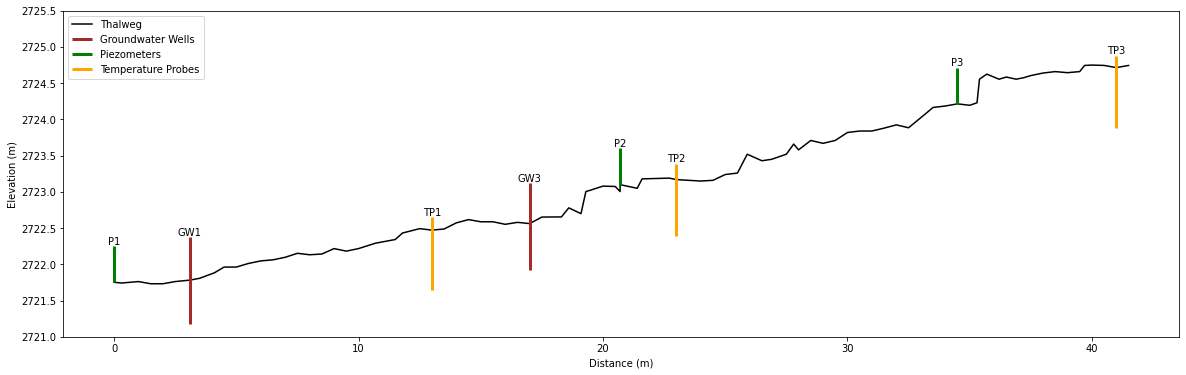

In [5]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
fig.patch.set_facecolor('white')  # set the figure's facecolor to white
ax.plot(down_reach.iloc[:, 0], down_reach.iloc[:, 1], label='Thalweg', color = 'black')


# add in groundwater wells 
# GW1
plt.vlines(wells.iloc[0,0], wells.iloc[0,1]-1.20, wells.iloc[0,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[0,0], wells.iloc[0,1], 'GW1', ha='center', va='bottom')
# GW3
plt.vlines(wells.iloc[2,0], wells.iloc[2,1]-1.20, wells.iloc[2,1], colors='brown', linewidth=3)
plt.text(wells.iloc[2,0], wells.iloc[2,1], 'GW3', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P1
plt.vlines(piezometers.iloc[0,0], piezometers.iloc[0,1]-0.5, piezometers.iloc[0,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[0,0], piezometers.iloc[0,1], 'P1', ha='center', va='bottom')
# P2
plt.vlines(piezometers.iloc[1,0], piezometers.iloc[1,1]-0.5, piezometers.iloc[1,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[1,0], piezometers.iloc[1,1], 'P2', ha='center', va='bottom')
# P3
plt.vlines(piezometers.iloc[2,0], piezometers.iloc[2,1]-0.5, piezometers.iloc[2,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[2,0], piezometers.iloc[2,1], 'P3', ha='center', va='bottom')

# add in temperature probes
# TP1
plt.vlines(temprobes.iloc[0,0], temprobes.iloc[0,1]-1, temprobes.iloc[0,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[0,0], temprobes.iloc[0,1], 'TP1', ha='center', va='bottom')
# TP2
plt.vlines(temprobes.iloc[1,0], temprobes.iloc[1,1]-1, temprobes.iloc[1,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[1,0], temprobes.iloc[1,1], 'TP2', ha='center', va='bottom')
# TP3
plt.vlines(temprobes.iloc[2,0], temprobes.iloc[2,1]-1, temprobes.iloc[2,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[2,0], temprobes.iloc[2,1], 'TP3', ha='center', va='bottom')

# Set the limits of the y-axis
ax.set_ylim(2721, 2725.5)

######## plotting the groundwater levels ########

#time_point = gw_data.index[0] # select a specific time point

#df_time_slice = GW1_3_SM21.loc[(time_point, slice(None))] # slice the DataFrame for the specific time point
# get the distances from the index
#distances = df_time_slice.index.get_level_values('distance')
# plot the groundwater level against distance
#ax.plot(distances, df_time_slice['gw_level'])

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
#ax.set_title(f'Downstream Long Profile and Left Bank Groudnwater Elevations at Time {time_point}')
ax.legend()

# Show the plot
plt.show()

Downstream Left Bank

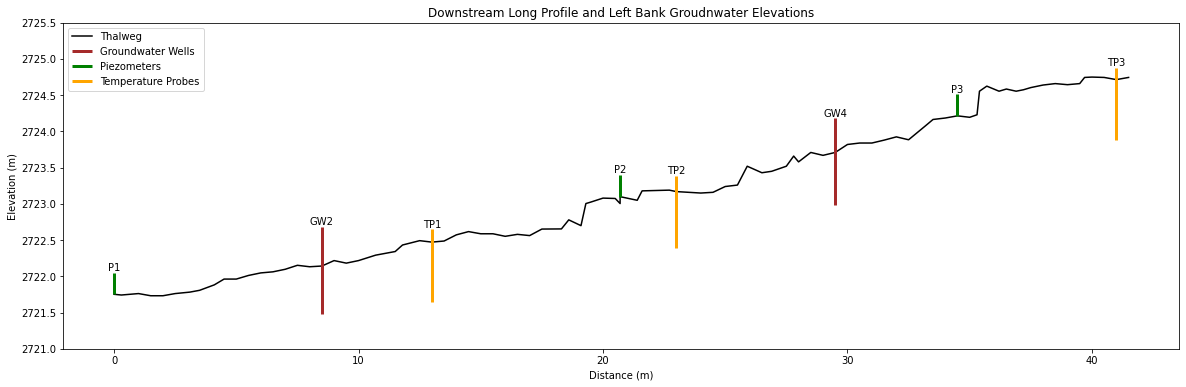

In [96]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(down_reach.iloc[:, 0], down_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW2
plt.vlines(wells.iloc[1,0], wells.iloc[1,1]-1.20, wells.iloc[1,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[1,0], wells.iloc[1,1], 'GW2', ha='center', va='bottom')
# GW4
plt.vlines(wells.iloc[3,0], wells.iloc[3,1]-1.20, wells.iloc[3,1], colors='brown', linewidth=3)
plt.text(wells.iloc[3,0], wells.iloc[3,1], 'GW4', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P1
plt.vlines(piezometers.iloc[0,0], piezometers.iloc[0,1]-0.3, piezometers.iloc[0,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[0,0], piezometers.iloc[0,1], 'P1', ha='center', va='bottom')
# P2
plt.vlines(piezometers.iloc[1,0], piezometers.iloc[1,1]-0.3, piezometers.iloc[1,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[1,0], piezometers.iloc[1,1], 'P2', ha='center', va='bottom')
# P3
plt.vlines(piezometers.iloc[2,0], piezometers.iloc[2,1]-0.3, piezometers.iloc[2,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[2,0], piezometers.iloc[2,1], 'P3', ha='center', va='bottom')

# add in temperature probes
# TP1
plt.vlines(temprobes.iloc[0,0], temprobes.iloc[0,1]-1, temprobes.iloc[0,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[0,0], temprobes.iloc[0,1], 'TP1', ha='center', va='bottom')
# TP2
plt.vlines(temprobes.iloc[1,0], temprobes.iloc[1,1]-1, temprobes.iloc[1,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[1,0], temprobes.iloc[1,1], 'TP2', ha='center', va='bottom')
# TP3
plt.vlines(temprobes.iloc[2,0], temprobes.iloc[2,1]-1, temprobes.iloc[2,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[2,0], temprobes.iloc[2,1], 'TP3', ha='center', va='bottom')

# Set the limits of the y-axis
ax.set_ylim(2721, 2725.5)

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Downstream Long Profile and Left Bank Groudnwater Elevations')
ax.legend()

# Show the plot
plt.show()

Upstream Right Bank

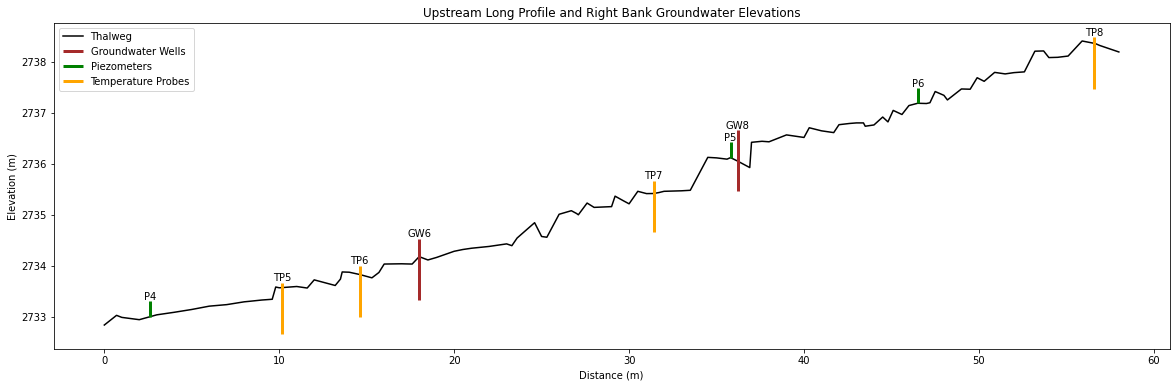

In [97]:
# Plot the upstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(up_reach.iloc[:, 0], up_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW6
plt.vlines(wells.iloc[5,0], wells.iloc[5,1]-1.20, wells.iloc[5,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[5,0], wells.iloc[5,1], 'GW6', ha='center', va='bottom')
# GW8
plt.vlines(wells.iloc[7,0], wells.iloc[7,1]-1.20, wells.iloc[7,1], colors='brown', linewidth=3)
plt.text(wells.iloc[7,0], wells.iloc[7,1], 'GW8', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P4
plt.vlines(piezometers.iloc[3,0], piezometers.iloc[3,1]-0.3, piezometers.iloc[3,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[3,0], piezometers.iloc[3,1], 'P4', ha='center', va='bottom')
# P5
plt.vlines(piezometers.iloc[4,0], piezometers.iloc[4,1]-0.3, piezometers.iloc[4,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[4,0], piezometers.iloc[4,1], 'P5', ha='center', va='bottom')
# P6
plt.vlines(piezometers.iloc[5,0], piezometers.iloc[5,1]-0.3, piezometers.iloc[5,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[5,0], piezometers.iloc[5,1], 'P6', ha='center', va='bottom')

# add in temperature probes
# TP5
plt.vlines(temprobes.iloc[4,0], temprobes.iloc[4,1]-1, temprobes.iloc[4,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[4,0], temprobes.iloc[4,1], 'TP5', ha='center', va='bottom')
# TP6
plt.vlines(temprobes.iloc[5,0], temprobes.iloc[5,1]-1, temprobes.iloc[5,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[5,0], temprobes.iloc[5,1], 'TP6', ha='center', va='bottom')
# TP7
plt.vlines(temprobes.iloc[6,0], temprobes.iloc[6,1]-1, temprobes.iloc[6,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[6,0], temprobes.iloc[6,1], 'TP7', ha='center', va='bottom')
# TP8
plt.vlines(temprobes.iloc[7,0], temprobes.iloc[7,1]-1, temprobes.iloc[7,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[7,0], temprobes.iloc[7,1], 'TP8', ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Upstream Long Profile and Right Bank Groundwater Elevations')
ax.legend()

# Show the plot
plt.show()

Upstream Left Bank

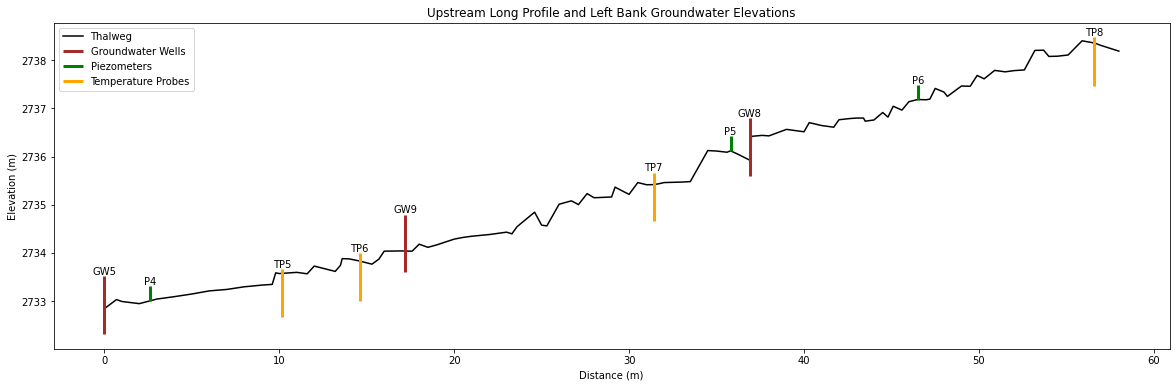

In [98]:
# Plot the downstream reach
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(up_reach.iloc[:, 0], up_reach.iloc[:, 1], label='Thalweg', color = 'black')

# add in groundwater wells 
# GW5
plt.vlines(wells.iloc[4,0], wells.iloc[4,1]-1.20, wells.iloc[4,1], colors='brown', linewidth=3, label='Groundwater Wells')
plt.text(wells.iloc[4,0], wells.iloc[4,1], 'GW5', ha='center', va='bottom')
# GW7
plt.vlines(wells.iloc[6,0], wells.iloc[6,1]-1.20, wells.iloc[6,1], colors='brown', linewidth=3)
plt.text(wells.iloc[6,0], wells.iloc[6,1], 'GW9', ha='center', va='bottom')
# GW9
plt.vlines(wells.iloc[8,0], wells.iloc[8,1]-1.20, wells.iloc[8,1], colors='brown', linewidth=3)
plt.text(wells.iloc[8,0], wells.iloc[8,1], 'GW8', ha='center', va='bottom')

# add in piezomenters/stilling wells
# P4
plt.vlines(piezometers.iloc[3,0], piezometers.iloc[3,1]-0.3, piezometers.iloc[3,1], colors='green', linewidth=3, label='Piezometers')
plt.text(piezometers.iloc[3,0], piezometers.iloc[3,1], 'P4', ha='center', va='bottom')
# P5
plt.vlines(piezometers.iloc[4,0], piezometers.iloc[4,1]-0.3, piezometers.iloc[4,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[4,0], piezometers.iloc[4,1], 'P5', ha='center', va='bottom')
# P6
plt.vlines(piezometers.iloc[5,0], piezometers.iloc[5,1]-0.3, piezometers.iloc[5,1], colors='green', linewidth=3)
plt.text(piezometers.iloc[5,0], piezometers.iloc[5,1], 'P6', ha='center', va='bottom')

# add in temperature probes
# TP5
plt.vlines(temprobes.iloc[4,0], temprobes.iloc[4,1]-1, temprobes.iloc[4,1], colors='orange', linewidth=3, label='Temperature Probes')
plt.text(temprobes.iloc[4,0], temprobes.iloc[4,1], 'TP5', ha='center', va='bottom')
# TP6
plt.vlines(temprobes.iloc[5,0], temprobes.iloc[5,1]-1, temprobes.iloc[5,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[5,0], temprobes.iloc[5,1], 'TP6', ha='center', va='bottom')
# TP7
plt.vlines(temprobes.iloc[6,0], temprobes.iloc[6,1]-1, temprobes.iloc[6,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[6,0], temprobes.iloc[6,1], 'TP7', ha='center', va='bottom')
# TP8
plt.vlines(temprobes.iloc[7,0], temprobes.iloc[7,1]-1, temprobes.iloc[7,1], colors='orange', linewidth=3)
plt.text(temprobes.iloc[7,0], temprobes.iloc[7,1], 'TP8', ha='center', va='bottom')

# Add labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Upstream Long Profile and Left Bank Groundwater Elevations')
ax.legend()

# Show the plot
plt.show()